In [1]:
# CS504 
# Team 1
# Data https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3/about_data

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_242455/912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import findspark
findspark.init()

In [4]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession 
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import col, to_date
from pyspark.sql.functions import col, unix_timestamp, round
from pyspark.sql.functions import col, datediff, hour, dayofweek

sc = SparkContext.getOrCreate()
# spark = SparkSession.builder.getOrCreate()
# print(sc.version)
# print(spark.version)

# from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("YourApp") \
    .config("spark.executor.memory", "12G") \
    .getOrCreate()

24/04/20 14:23:52 WARN Utils: Your hostname, debian resolves to a loopback address: 127.0.1.1; using 192.168.1.20 instead (on interface wlp61s0)
24/04/20 14:23:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/20 14:23:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/20 14:23:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/04/20 14:23:56 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/04/20 14:23:56 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/04/20 14:23:56 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [5]:
# read csv file with defined schema into Spark DataFrame, and use "," delimiter
df = spark.read.csv(
    "/home/pk/Downloads/fire.csv", 
    header=True, sep=",")
#show 3 rows of our DataFrame
df.show(3)

24/04/20 14:24:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+-------+---------------+----------------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+-------------+-------------------+---------+------------+----+-----------------+--------+--------------+--------+--------------------+----------------+---------+------------------------------+------------------------+-------------------+------------------------------------+-------------+--------------------+--------------------+--------------------+----------------------+
|Call Number|Unit ID|Incident Number|       Call Type| Call Date|Watch Date|       Received DtTm|          Entry DtTm|       Dispatch DtTm|       Response DtTm|       On Scene DtTm|      Transport DtTm|       Hospital DtTm|Call Final Disposition|      Available DtTm|             Address|         City|Zipcode of Incident|Battalion|Stati

In [6]:
#count number of rows of our dataFrame
num_rows = df.count()
print("number of rows: ", num_rows)

number of rows:  1992749


In [7]:
df.printSchema()

root
 |-- Call Number: string (nullable = true)
 |-- Unit ID: string (nullable = true)
 |-- Incident Number: string (nullable = true)
 |-- Call Type: string (nullable = true)
 |-- Call Date: string (nullable = true)
 |-- Watch Date: string (nullable = true)
 |-- Received DtTm: string (nullable = true)
 |-- Entry DtTm: string (nullable = true)
 |-- Dispatch DtTm: string (nullable = true)
 |-- Response DtTm: string (nullable = true)
 |-- On Scene DtTm: string (nullable = true)
 |-- Transport DtTm: string (nullable = true)
 |-- Hospital DtTm: string (nullable = true)
 |-- Call Final Disposition: string (nullable = true)
 |-- Available DtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode of Incident: string (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- Station Area: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- Original Priority: string (nullable = true)
 |-- Priority: string (nullable = 

In [8]:
# Rename columns to remove spaces
columns = df.columns
renamed_columns = [col.replace(" ", "_") for col in columns]
df = df.toDF(*renamed_columns)

In [9]:
# Convert date fields to datetime format
date_fields = ["Call_Date", "Watch_Date"]  
    
for field in date_fields:
    df = df.withColumn(field, to_date(df[field], "MM/dd/yyyy"))
    
    
# Convert date fields to datetime format
date_time_fields = ["Received_DtTm", "Entry_DtTm", "Dispatch_DtTm", "Response_DtTm", 
               "On_Scene_DtTm", "Transport_DtTm", "Hospital_DtTm", "Available_DtTm"]

# for field in date_fields:
#     df = df.withColumn(field, df[field].cast("timestamp"))
    
    
for field in date_time_fields:
    df = df.withColumn(field, to_timestamp(df[field], "MM/dd/yyyy hh:mm:ss a"))
    
df.printSchema()

root
 |-- Call_Number: string (nullable = true)
 |-- Unit_ID: string (nullable = true)
 |-- Incident_Number: string (nullable = true)
 |-- Call_Type: string (nullable = true)
 |-- Call_Date: date (nullable = true)
 |-- Watch_Date: date (nullable = true)
 |-- Received_DtTm: timestamp (nullable = true)
 |-- Entry_DtTm: timestamp (nullable = true)
 |-- Dispatch_DtTm: timestamp (nullable = true)
 |-- Response_DtTm: timestamp (nullable = true)
 |-- On_Scene_DtTm: timestamp (nullable = true)
 |-- Transport_DtTm: timestamp (nullable = true)
 |-- Hospital_DtTm: timestamp (nullable = true)
 |-- Call_Final_Disposition: string (nullable = true)
 |-- Available_DtTm: timestamp (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode_of_Incident: string (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- Station_Area: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- Original_Priority: string (nullable = true)
 |-- Priority:

In [10]:
# Filter out data (2018-2023 only)
df = df.filter(col("Call_Date") <= "2023-12-31")

In [11]:
#count number of rows of our dataFrame
num_rows = df.count()
print("number of rows: ", num_rows)

number of rows:  1910643


In [12]:
# Calculate Response_Time
# df = df.withColumn("Response_Time", (unix_timestamp("On_Scene_DtTm") - unix_timestamp("Received_DtTm")) / 60)
df = df.withColumn("Response_Time", round((unix_timestamp("On_Scene_DtTm") - unix_timestamp("Received_DtTm")) / 60, 2))
df = df.withColumn("Received_Hour", hour("Received_DtTm")).withColumn("Received_DayOfWeek", dayofweek("Received_DtTm"))

In [13]:
# Count the number of null values in the On_Scene_DtTm column
null_count = df.filter(col("On_Scene_DtTm").isNull()).count()

print("Number of null values in On_Scene_DtTm:", null_count)

Number of null values in On_Scene_DtTm: 375611


In [14]:
df.printSchema()

root
 |-- Call_Number: string (nullable = true)
 |-- Unit_ID: string (nullable = true)
 |-- Incident_Number: string (nullable = true)
 |-- Call_Type: string (nullable = true)
 |-- Call_Date: date (nullable = true)
 |-- Watch_Date: date (nullable = true)
 |-- Received_DtTm: timestamp (nullable = true)
 |-- Entry_DtTm: timestamp (nullable = true)
 |-- Dispatch_DtTm: timestamp (nullable = true)
 |-- Response_DtTm: timestamp (nullable = true)
 |-- On_Scene_DtTm: timestamp (nullable = true)
 |-- Transport_DtTm: timestamp (nullable = true)
 |-- Hospital_DtTm: timestamp (nullable = true)
 |-- Call_Final_Disposition: string (nullable = true)
 |-- Available_DtTm: timestamp (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode_of_Incident: string (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- Station_Area: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- Original_Priority: string (nullable = true)
 |-- Priority:

In [15]:
df.head()

Row(Call_Number='221840342', Unit_ID='54', Incident_Number='22084610', Call_Type='Medical Incident', Call_Date=datetime.date(2022, 7, 3), Watch_Date=datetime.date(2022, 7, 2), Received_DtTm=datetime.datetime(2022, 7, 3, 4, 21, 35), Entry_DtTm=datetime.datetime(2022, 7, 3, 4, 22, 15), Dispatch_DtTm=datetime.datetime(2022, 7, 3, 4, 22, 54), Response_DtTm=datetime.datetime(2022, 7, 3, 4, 23, 2), On_Scene_DtTm=datetime.datetime(2022, 7, 3, 4, 31), Transport_DtTm=datetime.datetime(2022, 7, 3, 4, 46, 12), Hospital_DtTm=datetime.datetime(2022, 7, 3, 4, 51, 41), Call_Final_Disposition='Code 2 Transport', Available_DtTm=datetime.datetime(2022, 7, 3, 5, 35, 31), Address='08TH ST/GROVE ST/HYDE ST/MARKET ST', City='San Francisco', Zipcode_of_Incident='94103', Battalion='B02', Station_Area='36', Box='2317', Original_Priority='3', Priority='3', Final_Priority='3', ALS_Unit='true', Call_Type_Group='Potentially Life-Threatening', Number_of_Alarms='1', Unit_Type='MEDIC', Unit_sequence_in_call_dispatch=

In [16]:
categorical_cols = [
    "Call_Type", "City","Zipcode_of_Incident", "Battalion", "Station_Area", "Original_Priority",
    "Priority", "Final_Priority", "ALS_Unit", "Call_Type_Group",
    "Unit_Type", "Unit_sequence_in_call_dispatch", "Fire_Prevention_District",
    "Supervisor_District", "Neighborhooods_-_Analysis_Boundaries","Received_Hour", "Received_DayOfWeek"
]


from pyspark.sql import functions as F

unique_counts_df = df.select(*(F.countDistinct(col).alias(col) for col in categorical_cols))
unique_counts_dict = unique_counts_df.first().asDict()

for key, val in unique_counts_dict.items():
    print(f"{key}: {val}")



Call_Type: 32
City: 8
Zipcode_of_Incident: 27
Battalion: 17
Station_Area: 46
Original_Priority: 9
Priority: 9
Final_Priority: 2
ALS_Unit: 2
Call_Type_Group: 4
Unit_Type: 12
Unit_sequence_in_call_dispatch: 104
Fire_Prevention_District: 11
Supervisor_District: 12
Neighborhooods_-_Analysis_Boundaries: 42
Received_Hour: 24
Received_DayOfWeek: 7


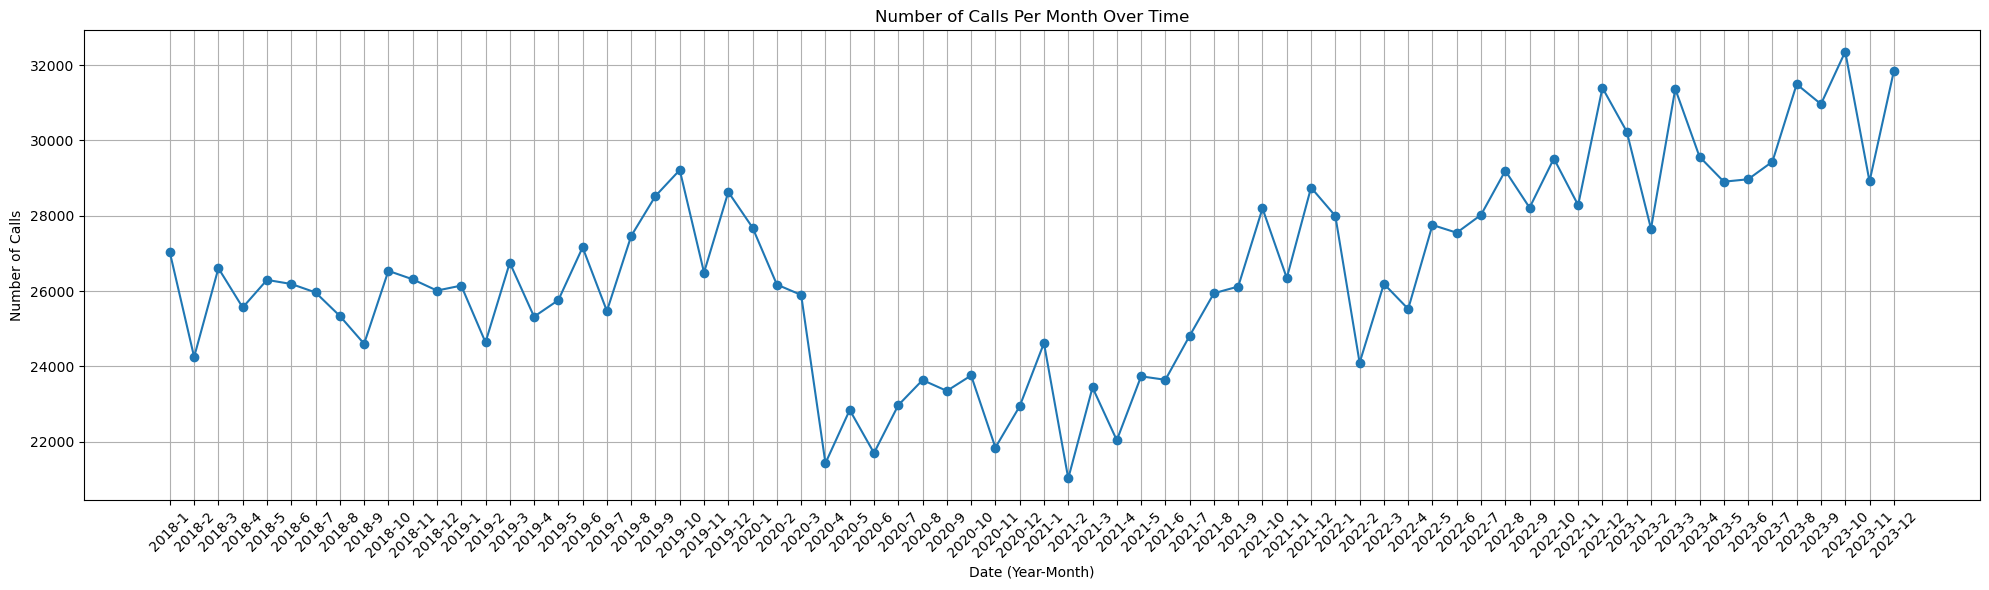

In [17]:
import matplotlib.pyplot as plt

# Register the DataFrame as a temporary view
df.createOrReplaceTempView("calls_data")

# Extract month and year from 'Call_Date'
df_with_month_year = spark.sql("""
    SELECT
        MONTH(Received_DtTm) AS month,
        YEAR(Received_DtTm) AS year
    FROM
        calls_data
""")

# Group by month and year, count the number of calls
calls_per_month = df_with_month_year.groupBy("year", "month").count().orderBy("year", "month")

# Convert the result to Pandas DataFrame for plotting
calls_per_month_pd = calls_per_month.toPandas()

# Plotting
plt.figure(figsize=(20, 6))
plt.plot(calls_per_month_pd["year"].astype(str) + "-" + calls_per_month_pd["month"].astype(str), calls_per_month_pd["count"], marker='o')
plt.xlabel("Date (Year-Month)")
plt.ylabel("Number of Calls")
plt.title("Number of Calls Per Month Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Run an SQL query on the DataFrame
result = spark.sql("""SELECT count(*) as counts, 
                   Call_Type,
                   YEAR(Received_DtTm) AS year
                   FROM calls_data 
                   group by Call_Type, YEAR(Received_DtTm)
                   order by year, counts desc
                   """)


result = spark.sql("""
    SELECT year,
           Call_Type,
           counts
    FROM (
        SELECT COUNT(*) AS counts,
               Call_Type,
               YEAR(Received_DtTm) AS year,
               ROW_NUMBER() OVER (PARTITION BY YEAR(Received_DtTm) ORDER BY COUNT(*) DESC) AS rn
        FROM calls_data
        GROUP BY Call_Type, YEAR(Received_DtTm)
    ) temp
    WHERE rn <= 5
    ORDER BY year, counts DESC
""")

# Show the result
result.show()

+----+--------------------+------+
|year|           Call_Type|counts|
+----+--------------------+------+
|2018|    Medical Incident|213938|
|2018|              Alarms| 35421|
|2018|Structure Fire / ...| 26757|
|2018|   Traffic Collision| 13353|
|2018|        Outside Fire|  4596|
|2019|    Medical Incident|220593|
|2019|              Alarms| 38561|
|2019|Structure Fire / ...| 25491|
|2019|   Traffic Collision| 13744|
|2019|Citizen Assist / ...|  4429|
|2020|    Medical Incident|192259|
|2020|              Alarms| 34848|
|2020|Structure Fire / ...| 21897|
|2020|   Traffic Collision| 10549|
|2020|        Outside Fire|  5697|
|2021|    Medical Incident|203342|
|2021|              Alarms| 37900|
|2021|Structure Fire / ...| 19469|
|2021|   Traffic Collision| 12092|
|2021|               Other|  6622|
+----+--------------------+------+
only showing top 20 rows



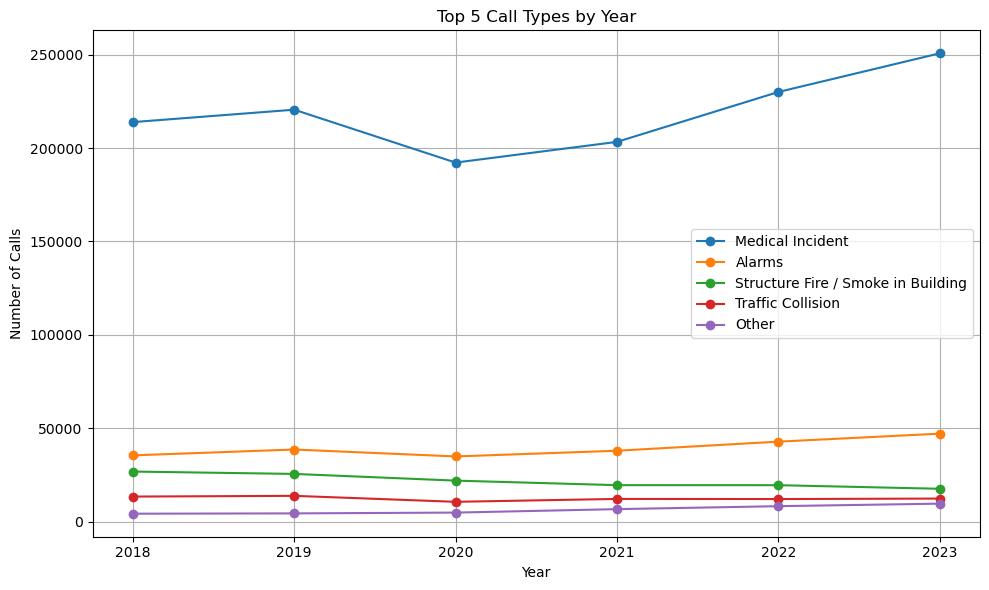

In [19]:
# Get the top 5 call types for all data
top_5_call_types_df = spark.sql("""
    SELECT Call_Type, count(*) as counts
    FROM calls_data
    GROUP BY Call_Type
    ORDER BY counts DESC
    LIMIT 5
""")

# Get the counts of top 5 call types by year
top_5_call_types_by_year_df = spark.sql("""
    SELECT Call_Type, YEAR(Received_DtTm) AS year, count(*) as counts
    FROM calls_data
    WHERE Call_Type IN (SELECT Call_Type FROM (
     SELECT Call_Type, count(*) as counts
    FROM calls_data
    GROUP BY Call_Type
    ORDER BY counts DESC
    LIMIT 5    
    ))
    GROUP BY Call_Type, YEAR(Received_DtTm)
    ORDER BY year, counts DESC
""")

# Convert the result to Pandas DataFrame for plotting
top_5_call_types_by_year_pd = top_5_call_types_by_year_df.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
for call_type in top_5_call_types_by_year_pd['Call_Type'].unique():
    data = top_5_call_types_by_year_pd[top_5_call_types_by_year_pd['Call_Type'] == call_type]
    plt.plot(data['year'], data['counts'], marker='o', label=call_type)
plt.xlabel("Year")
plt.ylabel("Number of Calls")
plt.title("Top 5 Call Types by Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



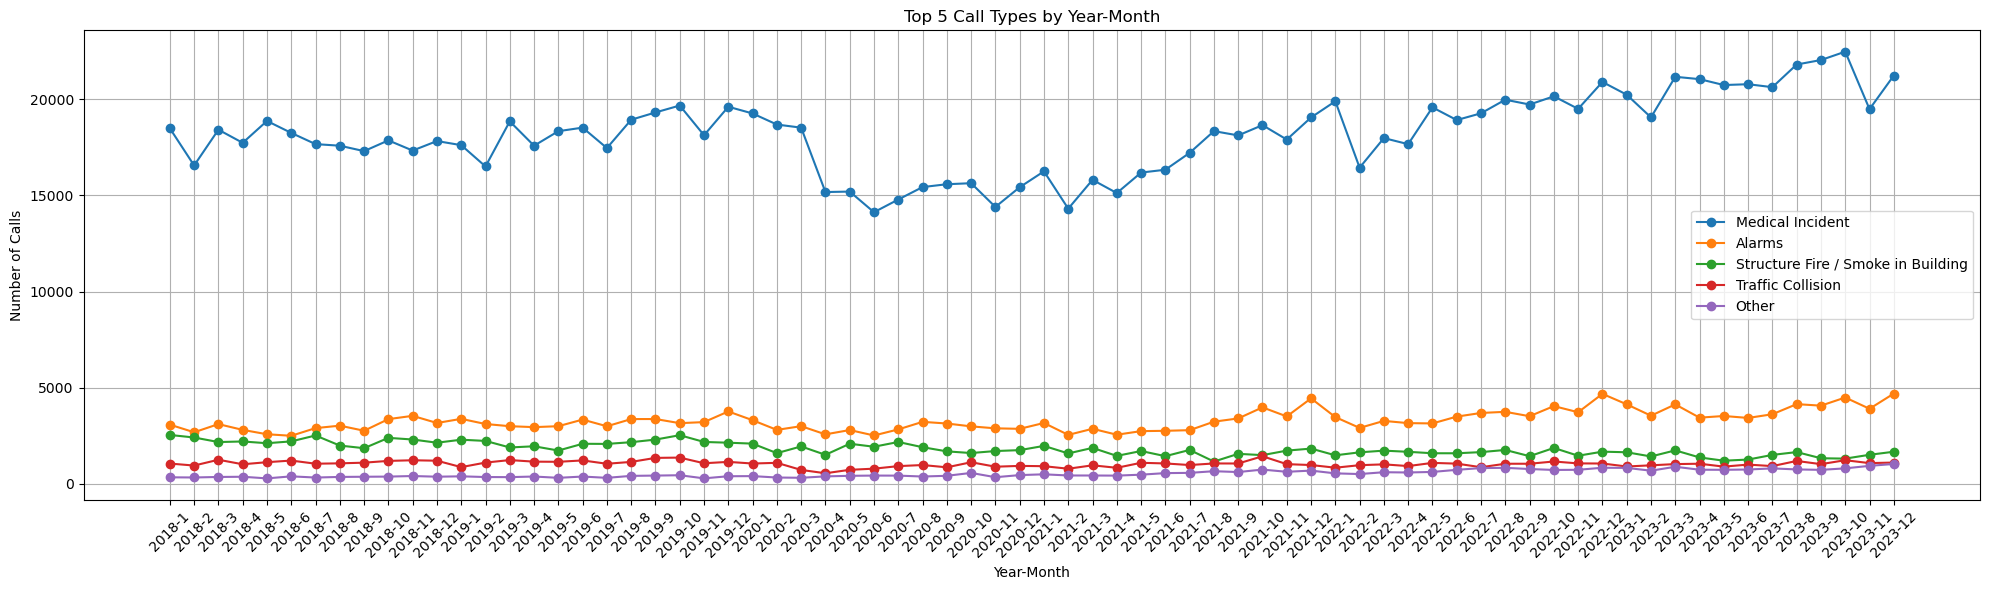

In [20]:
# Get the top 5 call types for all data and their counts by year-month
top_5_call_types_by_year_month_df = spark.sql("""
    SELECT Call_Type, 
           YEAR(Received_DtTm) AS year, 
           MONTH(Received_DtTm) AS month, 
           count(*) as counts
    FROM calls_data
    WHERE Call_Type IN (
        SELECT Call_Type
        FROM (
            SELECT Call_Type, count(*) as counts
            FROM calls_data
            GROUP BY Call_Type
            ORDER BY counts DESC
            LIMIT 5
        ) top_5_call_types
    )
    GROUP BY Call_Type, year, month
    ORDER BY year, month, counts DESC
""")

# Convert the result to Pandas DataFrame for plotting
top_5_call_types_by_year_month_pd = top_5_call_types_by_year_month_df.toPandas()

# Plotting
plt.figure(figsize=(20, 6))
for call_type in top_5_call_types_by_year_month_pd['Call_Type'].unique():
    data = top_5_call_types_by_year_month_pd[top_5_call_types_by_year_month_pd['Call_Type'] == call_type]
    plt.plot(data['year'].astype(str) + '-' + data['month'].astype(str), data['counts'], marker='o', label=call_type)
plt.xlabel("Year-Month")
plt.ylabel("Number of Calls")
plt.title("Top 5 Call Types by Year-Month")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

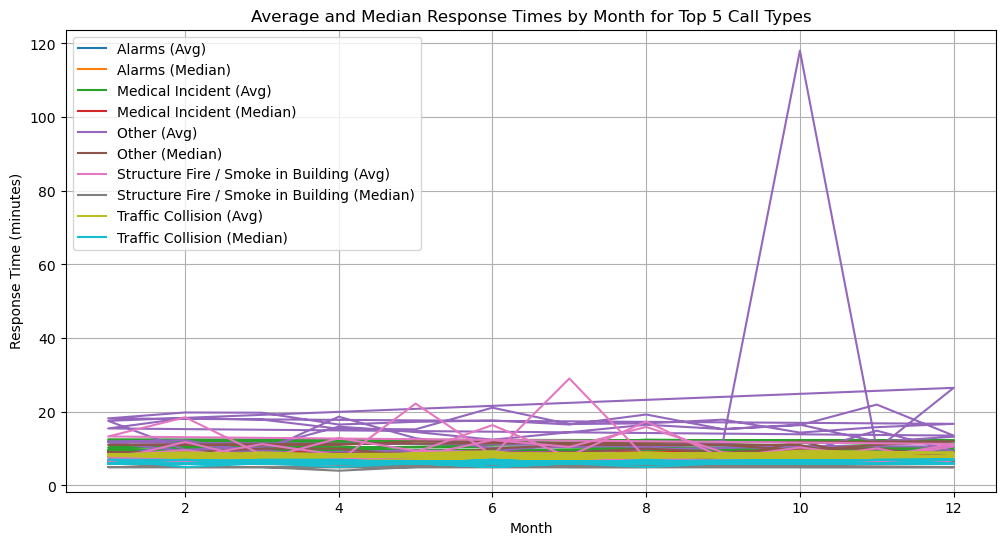

In [21]:
# Execute the Spark SQL query to calculate average and median response times by month and call type
response_times_df = spark.sql("""
    SELECT 
        Call_Type,
        YEAR(Received_DtTm) AS year,
        MONTH(Received_DtTm) AS month,
        AVG(TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS avg_response_time,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS median_response_time
    FROM 
        calls_data
    WHERE 
        Call_Type IN (
            SELECT 
                Call_Type
            FROM (
                SELECT 
                    Call_Type, 
                    COUNT(*) AS counts
                FROM 
                    calls_data
                GROUP BY 
                    Call_Type
                ORDER BY 
                    counts DESC
                LIMIT 5
            ) top_5_call_types
        )
    GROUP BY 
        Call_Type, 
        year, 
        month
    ORDER BY 
        year, 
        month, 
        Call_Type
""")

# Convert the result DataFrame to Pandas DataFrame for plotting
response_times_pd = response_times_df.toPandas()

# Plotting using Matplotlib
call_types = response_times_pd["Call_Type"].unique()
plt.figure(figsize=(12, 6))
for call_type in call_types:
    data = response_times_pd[response_times_pd["Call_Type"] == call_type]
    plt.plot(data["month"], data["avg_response_time"], label=f'{call_type} (Avg)')
    plt.plot(data["month"], data["median_response_time"], label=f'{call_type} (Median)')

plt.xlabel("Month")
plt.ylabel("Response Time (minutes)")
plt.title("Average and Median Response Times by Month for Top 5 Call Types")
plt.legend()
plt.grid(True)
plt.show()


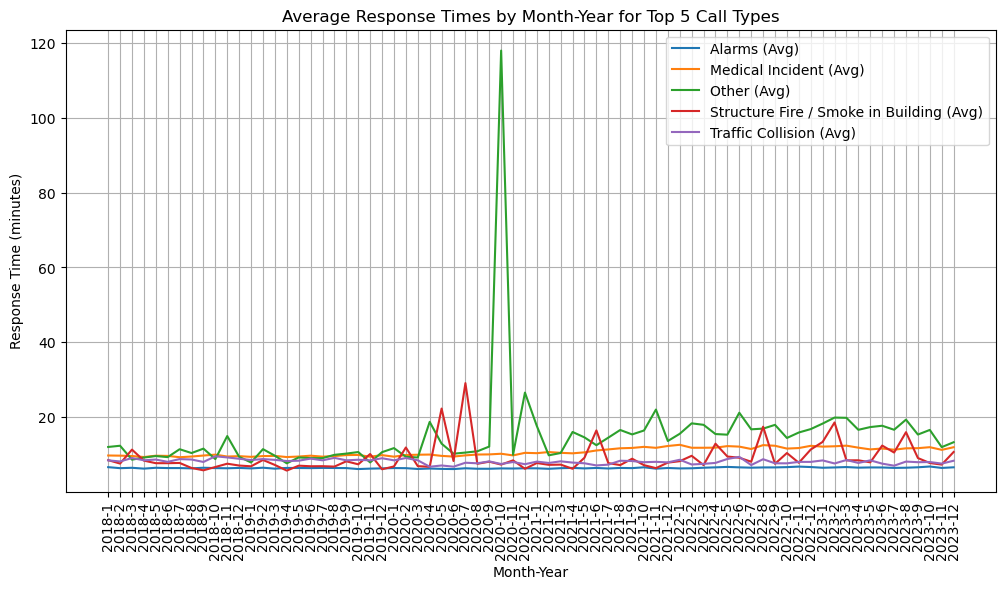

In [22]:
# Execute the Spark SQL query to calculate average and median response times by month and year
response_times_df = spark.sql("""
    SELECT 
        Call_Type,
        YEAR(Received_DtTm) AS year,
        MONTH(Received_DtTm) AS month,
        AVG(TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS avg_response_time
        --PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS median_response_time
    FROM 
        calls_data
    WHERE 
        Call_Type IN (
            SELECT 
                Call_Type
            FROM (
                SELECT 
                    Call_Type, 
                    COUNT(*) AS counts
                FROM 
                    calls_data
                GROUP BY 
                    Call_Type
                ORDER BY 
                    counts DESC
                LIMIT 5
            ) top_5_call_types
        )
    GROUP BY 
        Call_Type, 
        year, 
        month
    ORDER BY 
        year, 
        month, 
        Call_Type
""")

# Convert the result DataFrame to Pandas DataFrame for plotting
response_times_pd = response_times_df.toPandas()

# Plotting using Matplotlib
call_types = response_times_pd["Call_Type"].unique()
plt.figure(figsize=(12, 6))
for call_type in call_types:
    data = response_times_pd[response_times_pd["Call_Type"] == call_type]
    plt.plot(data["year"].astype(str) + "-" + data["month"].astype(str), data["avg_response_time"], label=f'{call_type} (Avg)')
    #plt.plot(data["year"].astype(str) + "-" + data["month"].astype(str), data["median_response_time"], label=f'{call_type} (Median)')

plt.xlabel("Month-Year")
plt.ylabel("Response Time (minutes)")
plt.title("Average Response Times by Month-Year for Top 5 Call Types")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


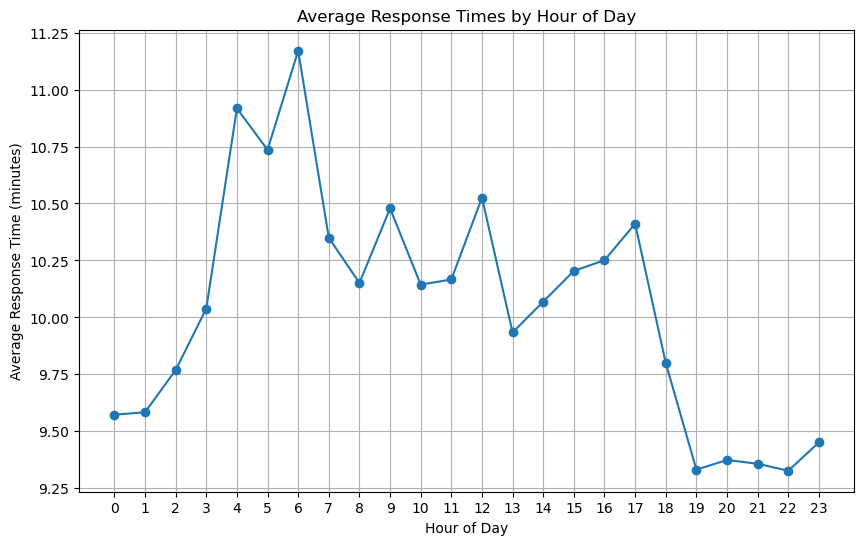

In [23]:
# Execute the Spark SQL query to calculate average response times by time of day
response_times_by_time_df = spark.sql("""
    SELECT 
        HOUR(Received_DtTm) AS hour_of_day,
        AVG(TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS avg_response_time
    FROM 
        calls_data
    WHERE 
        Call_Type IN (
            SELECT 
                Call_Type
            FROM (
                SELECT 
                    Call_Type, 
                    COUNT(*) AS counts
                FROM 
                    calls_data
                GROUP BY 
                    Call_Type
                ORDER BY 
                    counts DESC
                LIMIT 5
            ) top_5_call_types
        )
    GROUP BY 
        hour_of_day
    ORDER BY 
        hour_of_day
""")

# Convert the result DataFrame to Pandas DataFrame for plotting
response_times_by_time_pd = response_times_by_time_df.toPandas()

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(response_times_by_time_pd["hour_of_day"], response_times_by_time_pd["avg_response_time"], marker='o')
plt.xlabel("Hour of Day")
plt.ylabel("Average Response Time (minutes)")
plt.title("Average Response Times by Hour of Day")
plt.grid(True)
plt.xticks(range(24))
plt.show()


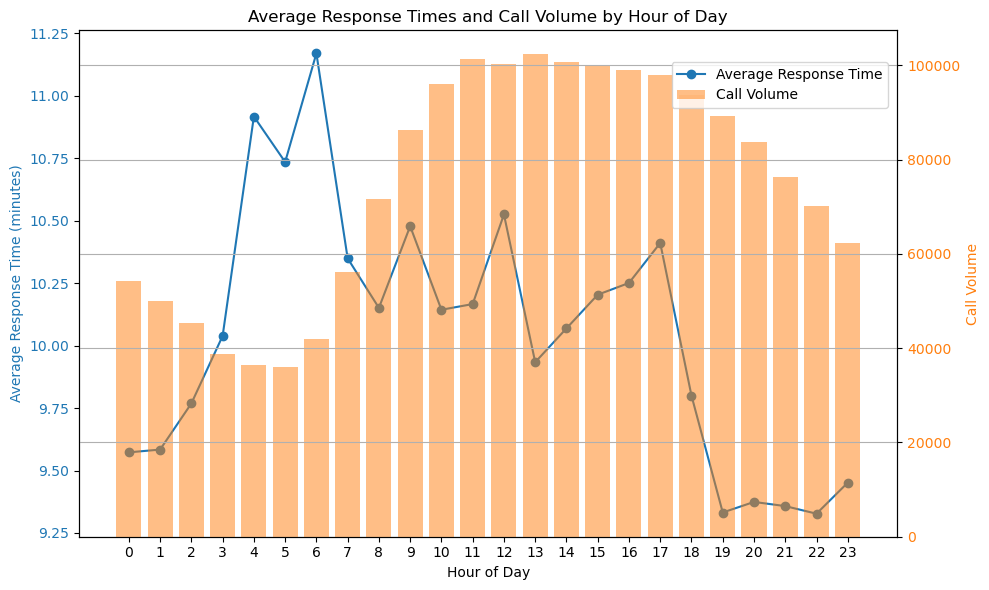

In [24]:
# Execute the Spark SQL query to calculate average response times and call volume by time of day
response_volume_and_time_df = spark.sql("""
    SELECT 
        HOUR(Received_DtTm) AS hour_of_day,
        AVG(TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS avg_response_time,
        COUNT(*) AS call_volume
    FROM 
        calls_data
    WHERE 
        Call_Type IN (
            SELECT 
                Call_Type
            FROM (
                SELECT 
                    Call_Type, 
                    COUNT(*) AS counts
                FROM 
                    calls_data
                GROUP BY 
                    Call_Type
                ORDER BY 
                    counts DESC
                LIMIT 5
            ) top_5_call_types
        )
    GROUP BY 
        hour_of_day
    ORDER BY 
        hour_of_day
""")

# Convert the result DataFrame to Pandas DataFrame for plotting
response_volume_and_time_pd = response_volume_and_time_df.toPandas()

# Plotting using Matplotlib
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average response time
ax1.plot(response_volume_and_time_pd["hour_of_day"], response_volume_and_time_pd["avg_response_time"], marker='o', color='tab:blue', label='Average Response Time')
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Average Response Time (minutes)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for call volume
ax2 = ax1.twinx()
ax2.bar(response_volume_and_time_pd["hour_of_day"], response_volume_and_time_pd["call_volume"], color='tab:orange', alpha=0.5, label='Call Volume')
ax2.set_ylabel("Call Volume", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Set title and grid
plt.title("Average Response Times and Call Volume by Hour of Day")
plt.grid(True)
plt.xticks(range(24))

# Show legend
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.show()


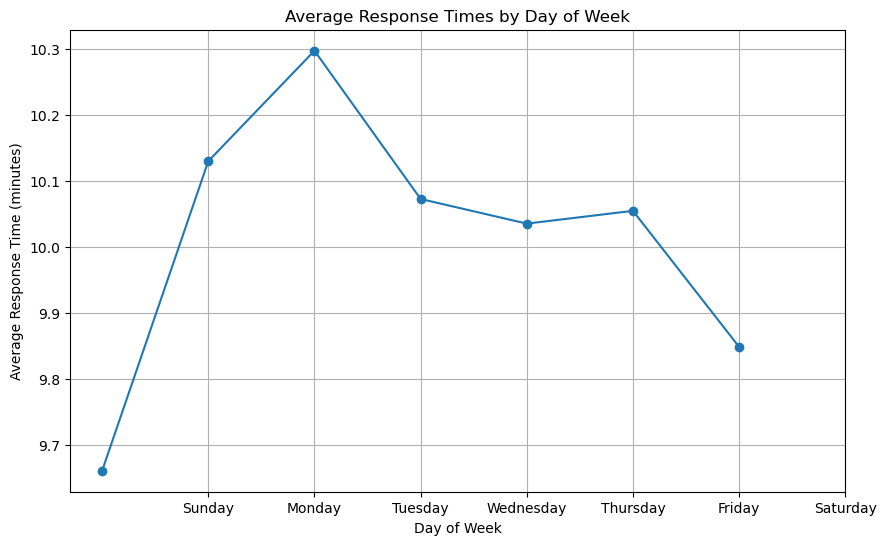

In [25]:
# Execute the Spark SQL query to calculate average response times by day of week
response_times_by_day_df = spark.sql("""
    SELECT 
        DAYOFWEEK(Received_DtTm) AS day_of_week,
        AVG(TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS avg_response_time
    FROM 
        calls_data
    WHERE 
        Call_Type IN (
            SELECT 
                Call_Type
            FROM (
                SELECT 
                    Call_Type, 
                    COUNT(*) AS counts
                FROM 
                    calls_data
                GROUP BY 
                    Call_Type
                ORDER BY 
                    counts DESC
                LIMIT 5
            ) top_5_call_types
        )
    GROUP BY 
        day_of_week
    ORDER BY 
        day_of_week
""")

# Convert the result DataFrame to Pandas DataFrame for plotting
response_times_by_day_pd = response_times_by_day_df.toPandas()

# Define the day of week labels
day_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(day_labels, response_times_by_day_pd["avg_response_time"], marker='o')
plt.xlabel("Day of Week")
plt.ylabel("Average Response Time (minutes)")
plt.title("Average Response Times by Day of Week")
plt.grid(True)
plt.xticks(range(1, 8), day_labels)  # Adjust x-axis ticks to show day labels
plt.show()


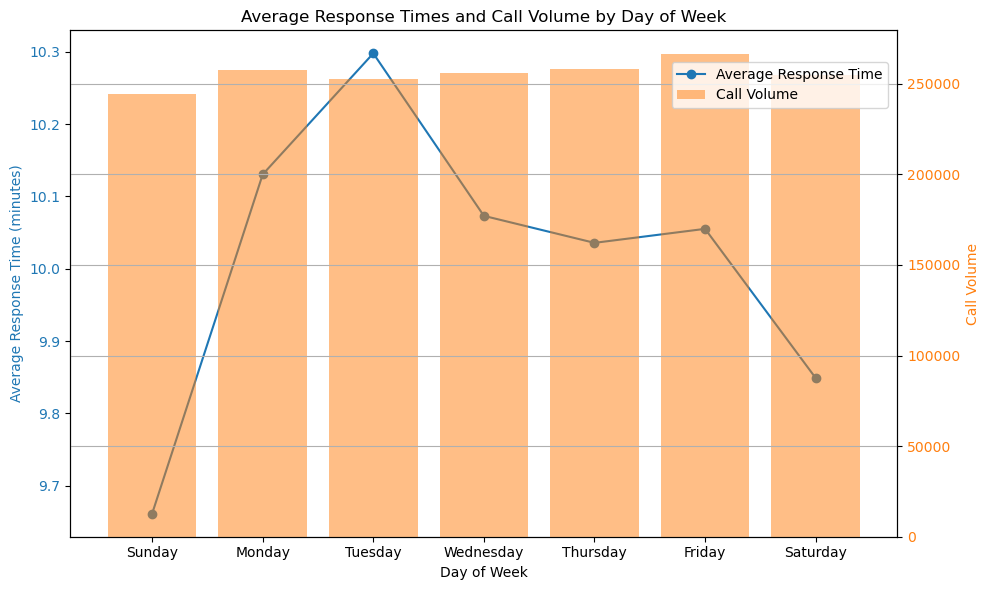

In [26]:
# Execute the Spark SQL query to calculate average response times and call volume by day of week
response_times_and_volume_df = spark.sql("""
    SELECT 
        DAYOFWEEK(Received_DtTm) AS day_of_week,
        AVG(TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS avg_response_time,
        COUNT(*) AS call_volume
    FROM 
        calls_data
    WHERE 
        Call_Type IN (
            SELECT 
                Call_Type
            FROM (
                SELECT 
                    Call_Type, 
                    COUNT(*) AS counts
                FROM 
                    calls_data
                GROUP BY 
                    Call_Type
                ORDER BY 
                    counts DESC
                LIMIT 5
            ) top_5_call_types
        )
    GROUP BY 
        day_of_week
    ORDER BY 
        day_of_week
""")

# Convert the result DataFrame to Pandas DataFrame for plotting
response_times_and_volume_pd = response_times_and_volume_df.toPandas()

# Define the day of week labels
day_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Plotting using Matplotlib
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average response time
ax1.plot(day_labels, response_times_and_volume_pd["avg_response_time"], marker='o', color='tab:blue', label='Average Response Time')
ax1.set_xlabel("Day of Week")
ax1.set_ylabel("Average Response Time (minutes)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for call volume
ax2 = ax1.twinx()
ax2.bar(day_labels, response_times_and_volume_pd["call_volume"], color='tab:orange', alpha=0.5, label='Call Volume')
ax2.set_ylabel("Call Volume", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Set title and grid
plt.title("Average Response Times and Call Volume by Day of Week")
plt.grid(True)

# Show legend
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.show()


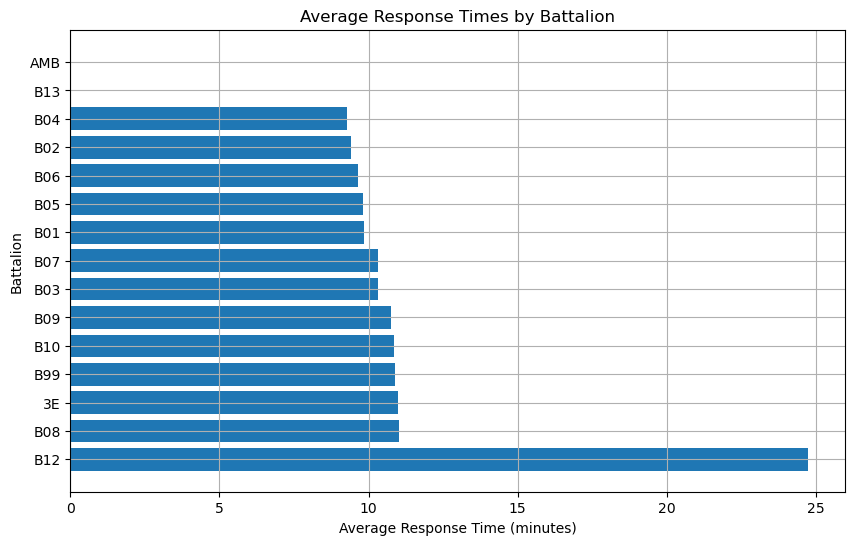

In [27]:
# Execute the Spark SQL query to calculate average response times by department/team
response_times_by_department_df = spark.sql("""
    SELECT 
        Battalion,
        AVG(TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS avg_response_time
    FROM 
        calls_data
    WHERE 
        Call_Type IN (
            SELECT 
                Call_Type
            FROM (
                SELECT 
                    Call_Type, 
                    COUNT(*) AS counts
                FROM 
                    calls_data
                GROUP BY 
                    Call_Type
                ORDER BY 
                    counts DESC
                LIMIT 5
            ) top_5_call_types
        )
    GROUP BY 
        Battalion
    ORDER BY 
        avg_response_time DESC
""")

# Convert the result DataFrame to Pandas DataFrame for plotting
response_times_by_department_pd = response_times_by_department_df.toPandas()

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.barh(response_times_by_department_pd["Battalion"], response_times_by_department_pd["avg_response_time"])
plt.xlabel("Average Response Time (minutes)")
plt.ylabel("Battalion")
plt.title("Average Response Times by Battalion")
plt.grid(True)
plt.show()



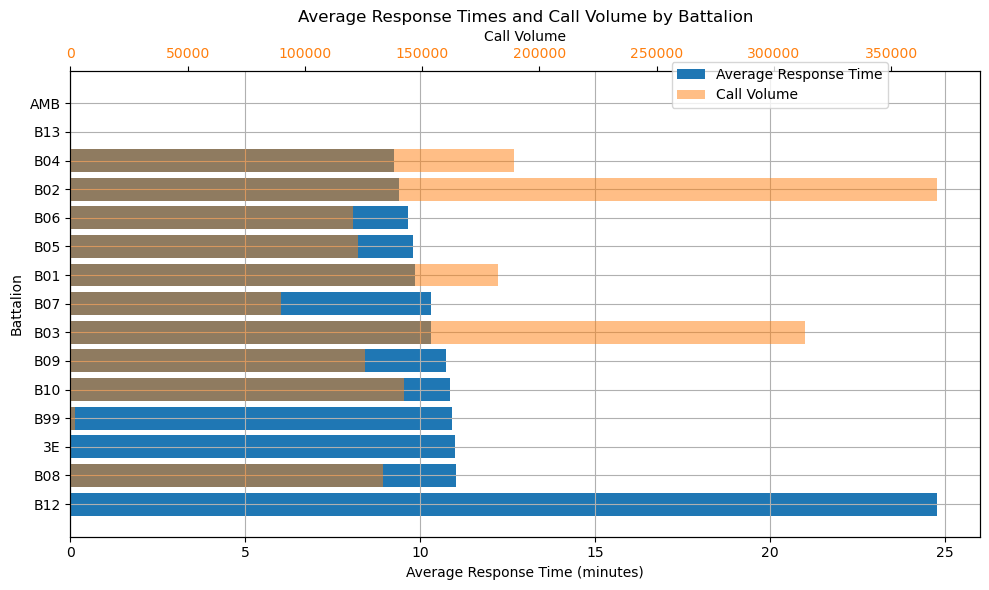

In [28]:
# Execute the Spark SQL query to calculate average response times and call volume by department/team (Battalion)
response_times_and_volume_by_department_df = spark.sql("""
    SELECT 
        Battalion,
        AVG(TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS avg_response_time,
        COUNT(*) AS call_volume
    FROM 
        calls_data
    WHERE 
        Call_Type IN (
            SELECT 
                Call_Type
            FROM (
                SELECT 
                    Call_Type, 
                    COUNT(*) AS counts
                FROM 
                    calls_data
                GROUP BY 
                    Call_Type
                ORDER BY 
                    counts DESC
                LIMIT 5
            ) top_5_call_types
        )
    GROUP BY 
        Battalion
    ORDER BY 
        avg_response_time DESC
""")

# Convert the result DataFrame to Pandas DataFrame for plotting
response_times_and_volume_by_department_pd = response_times_and_volume_by_department_df.toPandas()

# Plotting using Matplotlib
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average response time
ax1.barh(response_times_and_volume_by_department_pd["Battalion"], response_times_and_volume_by_department_pd["avg_response_time"], color='tab:blue', label='Average Response Time')
ax1.set_xlabel("Average Response Time (minutes)")
ax1.set_ylabel("Battalion")
ax1.set_title("Average Response Times and Call Volume by Battalion")
ax1.grid(True)

# Create a second x-axis for call volume
ax2 = ax1.twiny()
ax2.barh(response_times_and_volume_by_department_pd["Battalion"], response_times_and_volume_by_department_pd["call_volume"], color='tab:orange', alpha=0.5, label='Call Volume')
ax2.set_xlabel("Call Volume")
ax2.tick_params(axis='x', labelcolor='tab:orange')

# Show legend
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.show()


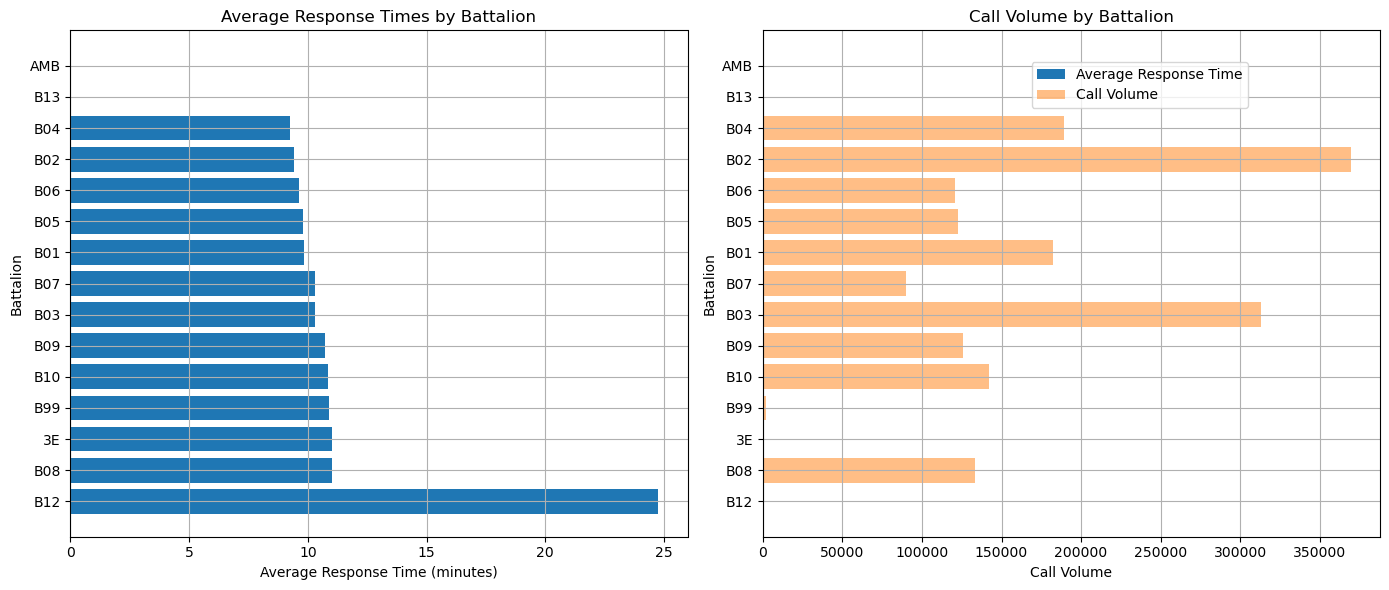

In [29]:
# Execute the Spark SQL query to calculate average response times and call volume by department/team
response_times_and_volume_by_department_df = spark.sql("""
    SELECT 
        Battalion,
        AVG(TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS avg_response_time,
        COUNT(*) AS call_volume
    FROM 
        calls_data
    WHERE 
        Call_Type IN (
            SELECT 
                Call_Type
            FROM (
                SELECT 
                    Call_Type, 
                    COUNT(*) AS counts
                FROM 
                    calls_data
                GROUP BY 
                    Call_Type
                ORDER BY 
                    counts DESC
                LIMIT 5
            ) top_5_call_types
        )
    GROUP BY 
        Battalion
    ORDER BY 
        avg_response_time DESC
""")

# Convert the result DataFrame to Pandas DataFrame for plotting
response_times_and_volume_by_department_pd = response_times_and_volume_by_department_df.toPandas()

# Plotting using Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot average response time
ax1.barh(response_times_and_volume_by_department_pd["Battalion"], response_times_and_volume_by_department_pd["avg_response_time"], color='tab:blue', label='Average Response Time')
ax1.set_xlabel("Average Response Time (minutes)")
ax1.set_ylabel("Battalion")
ax1.set_title("Average Response Times by Battalion")
ax1.grid(True)

# Plot call volume
ax2.barh(response_times_and_volume_by_department_pd["Battalion"], response_times_and_volume_by_department_pd["call_volume"], color='tab:orange', alpha=0.5, label='Call Volume')
ax2.set_xlabel("Call Volume")
ax2.set_ylabel("Battalion")
ax2.set_title("Call Volume by Battalion")
ax2.grid(True)

# Show legend
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.show()


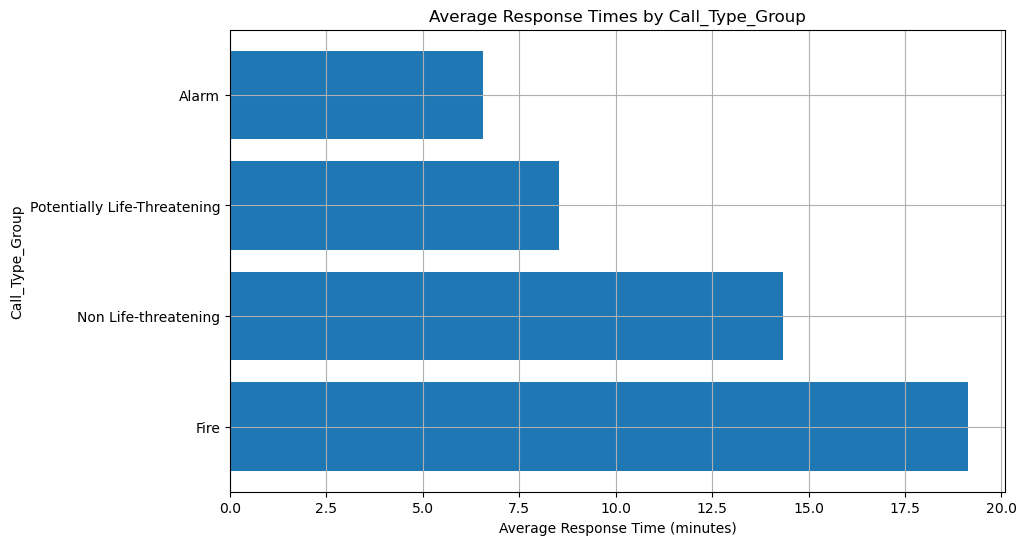

In [30]:
# Execute the Spark SQL query to calculate average response times by department/team
response_times_by_department_df = spark.sql("""
    SELECT 
        Call_Type_Group,
        AVG(TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS avg_response_time
    FROM 
        calls_data
    WHERE 
        Call_Type_Group IS NOT NULL  -- Filter out rows with null Call_Type_Group
        AND Call_Type IN (
            SELECT 
                Call_Type
            FROM (
                SELECT 
                    Call_Type, 
                    COUNT(*) AS counts
                FROM 
                    calls_data
                GROUP BY 
                    Call_Type
                ORDER BY 
                    counts DESC
                LIMIT 5
            ) top_5_call_types
        )
    GROUP BY 
        Call_Type_Group
    ORDER BY 
        avg_response_time DESC
""")

# Convert the result DataFrame to Pandas DataFrame for plotting
response_times_by_department_pd = response_times_by_department_df.toPandas()

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.barh(response_times_by_department_pd["Call_Type_Group"], response_times_by_department_pd["avg_response_time"])
plt.xlabel("Average Response Time (minutes)")
plt.ylabel("Call_Type_Group")
plt.title("Average Response Times by Call_Type_Group")
plt.grid(True)
plt.show()


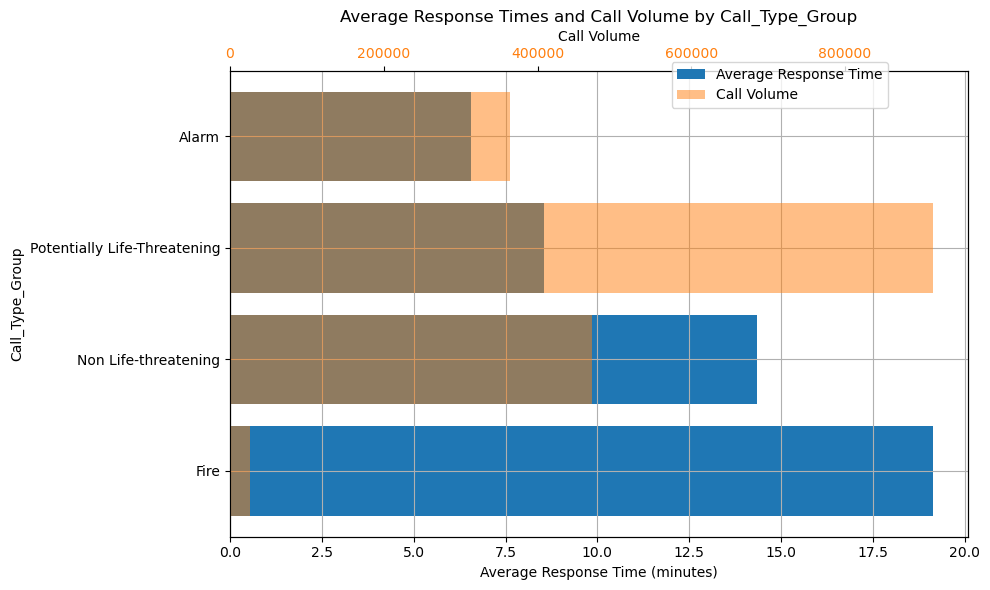

In [31]:
# Execute the Spark SQL query to calculate average response times and call volume by department/team
response_times_and_volume_by_department_df = spark.sql("""
    SELECT 
        Call_Type_Group,
        AVG(TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS avg_response_time,
        COUNT(*) AS call_volume
    FROM 
        calls_data
    WHERE 
        Call_Type_Group IS NOT NULL  -- Filter out rows with null Call_Type_Group
        AND Call_Type IN (
            SELECT 
                Call_Type
            FROM (
                SELECT 
                    Call_Type, 
                    COUNT(*) AS counts
                FROM 
                    calls_data
                GROUP BY 
                    Call_Type
                ORDER BY 
                    counts DESC
                LIMIT 5
            ) top_5_call_types
        )
    GROUP BY 
        Call_Type_Group
    ORDER BY 
        avg_response_time DESC
""")

# Convert the result DataFrame to Pandas DataFrame for plotting
response_times_and_volume_by_department_pd = response_times_and_volume_by_department_df.toPandas()

# Plotting using Matplotlib
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average response time
ax1.barh(response_times_and_volume_by_department_pd["Call_Type_Group"], response_times_and_volume_by_department_pd["avg_response_time"], color='tab:blue', label='Average Response Time')
ax1.set_xlabel("Average Response Time (minutes)")
ax1.set_ylabel("Call_Type_Group")
ax1.set_title("Average Response Times and Call Volume by Call_Type_Group")
ax1.grid(True)

# Create a second x-axis for call volume
ax2 = ax1.twiny()
ax2.barh(response_times_and_volume_by_department_pd["Call_Type_Group"], response_times_and_volume_by_department_pd["call_volume"], color='tab:orange', alpha=0.5, label='Call Volume')
ax2.set_xlabel("Call Volume")
ax2.tick_params(axis='x', labelcolor='tab:orange')

# Show legend
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.show()


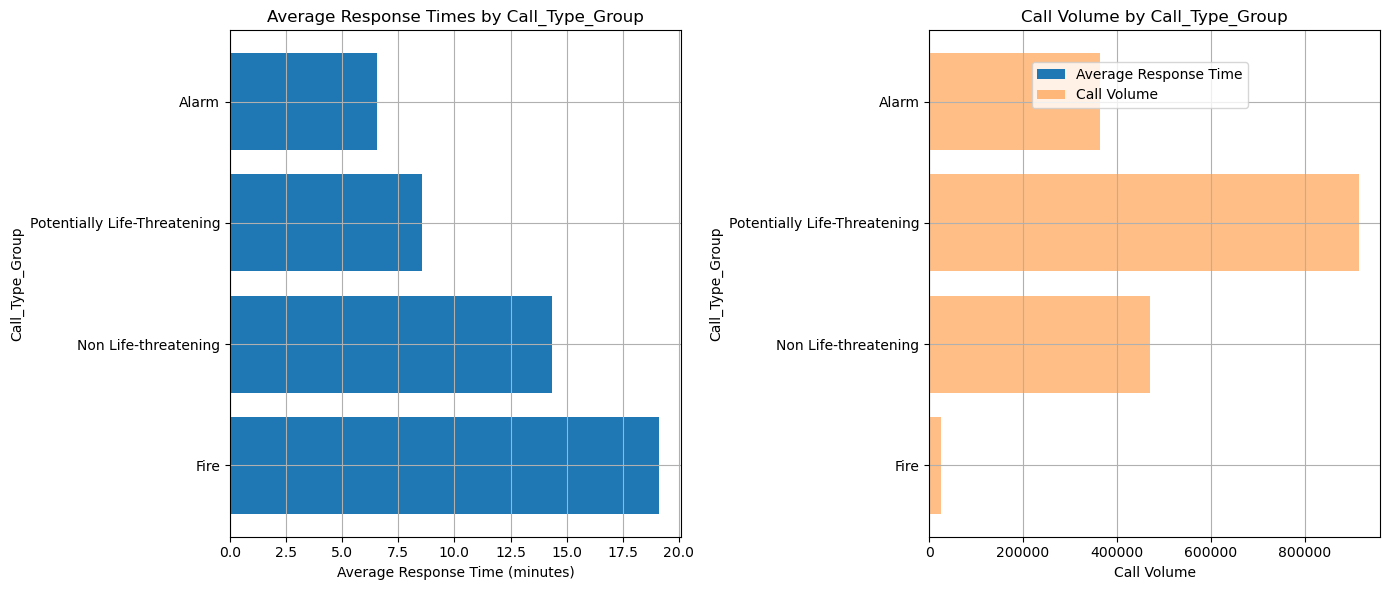

In [32]:
# Execute the Spark SQL query to calculate average response times and call volume by department/team
response_times_and_volume_by_department_df = spark.sql("""
    SELECT 
        Call_Type_Group,
        AVG(TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS avg_response_time,
        COUNT(*) AS call_volume
    FROM 
        calls_data
    WHERE 
        Call_Type_Group IS NOT NULL  -- Filter out rows with null Call_Type_Group
        AND Call_Type IN (
            SELECT 
                Call_Type
            FROM (
                SELECT 
                    Call_Type, 
                    COUNT(*) AS counts
                FROM 
                    calls_data
                GROUP BY 
                    Call_Type
                ORDER BY 
                    counts DESC
                LIMIT 5
            ) top_5_call_types
        )
    GROUP BY 
        Call_Type_Group
    ORDER BY 
        avg_response_time DESC
""")

# Convert the result DataFrame to Pandas DataFrame for plotting
response_times_and_volume_by_department_pd = response_times_and_volume_by_department_df.toPandas()

# Plotting using Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot average response time
ax1.barh(response_times_and_volume_by_department_pd["Call_Type_Group"], response_times_and_volume_by_department_pd["avg_response_time"], color='tab:blue', label='Average Response Time')
ax1.set_xlabel("Average Response Time (minutes)")
ax1.set_ylabel("Call_Type_Group")
ax1.set_title("Average Response Times by Call_Type_Group")
ax1.grid(True)

# Plot call volume
ax2.barh(response_times_and_volume_by_department_pd["Call_Type_Group"], response_times_and_volume_by_department_pd["call_volume"], color='tab:orange', alpha=0.5, label='Call Volume')
ax2.set_xlabel("Call Volume")
ax2.set_ylabel("Call_Type_Group")
ax2.set_title("Call Volume by Call_Type_Group")
ax2.grid(True)

# Show legend
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.show()


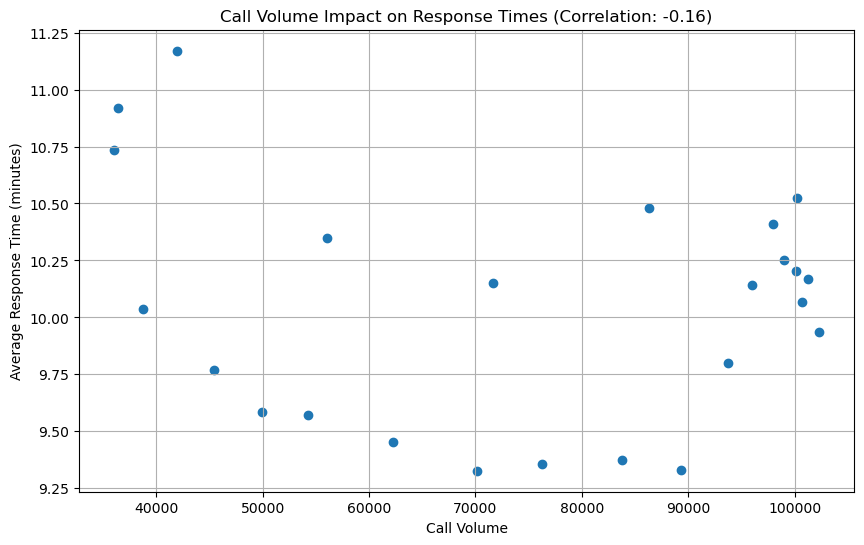

In [33]:
# Execute the Spark SQL query to calculate call volume and average response times by hour
call_volume_response_times_df = spark.sql("""
    SELECT 
        HOUR(Received_DtTm) AS hour_of_day,
        COUNT(*) AS call_volume,
        AVG(TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS avg_response_time
    FROM 
        calls_data
    WHERE 
        Call_Type IN (
            SELECT 
                Call_Type
            FROM (
                SELECT 
                    Call_Type, 
                    COUNT(*) AS counts
                FROM 
                    calls_data
                GROUP BY 
                    Call_Type
                ORDER BY 
                    counts DESC
                LIMIT 5
            ) top_5_call_types
        )
    GROUP BY 
        hour_of_day
    ORDER BY 
        hour_of_day
""")

# Convert the result DataFrame to Pandas DataFrame for analysis
call_volume_response_times_pd = call_volume_response_times_df.toPandas()

# Calculate correlation between call volume and average response time
correlation_coefficient = call_volume_response_times_pd['call_volume'].corr(call_volume_response_times_pd['avg_response_time'])

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(call_volume_response_times_pd['call_volume'], call_volume_response_times_pd['avg_response_time'])
plt.xlabel("Call Volume")
plt.ylabel("Average Response Time (minutes)")
plt.title(f"Call Volume Impact on Response Times (Correlation: {correlation_coefficient:.2f})")
plt.grid(True)
plt.show()


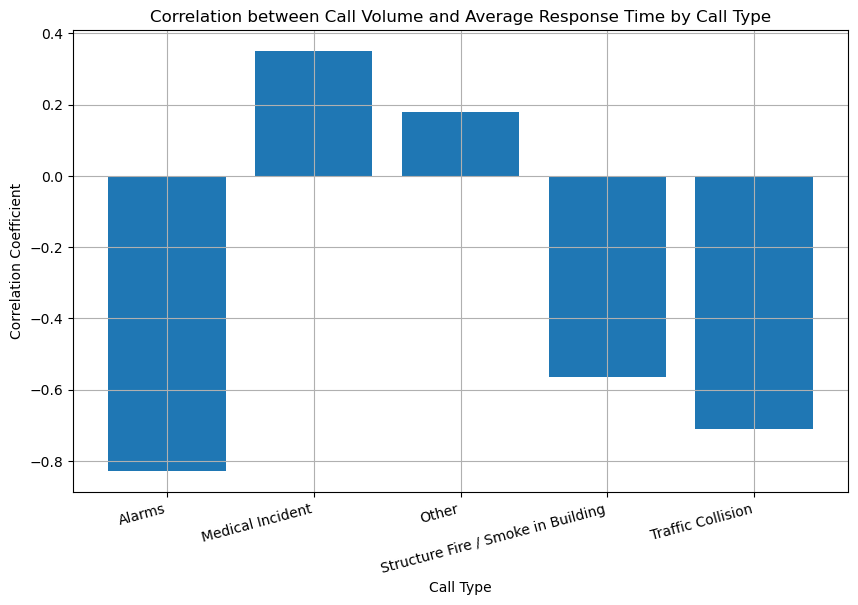

In [34]:
import matplotlib.pyplot as plt

# Execute the Spark SQL query to calculate call volume and average response times by hour and call type
call_volume_response_times_df = spark.sql("""
    SELECT 
        HOUR(Received_DtTm) AS hour_of_day,
        Call_Type,
        COUNT(*) AS call_volume,
        AVG(TIMESTAMPDIFF(MINUTE, Received_DtTm, On_Scene_DtTm)) AS avg_response_time
    FROM 
        calls_data
    WHERE 
        Call_Type IN (
            SELECT 
                Call_Type
            FROM (
                SELECT 
                    Call_Type, 
                    COUNT(*) AS counts
                FROM 
                    calls_data
                GROUP BY 
                    Call_Type
                ORDER BY 
                    counts DESC
                LIMIT 5
            ) top_5_call_types
        )
    GROUP BY 
        hour_of_day, Call_Type
    ORDER BY 
        hour_of_day, Call_Type
""")

# Convert the result DataFrame to Pandas DataFrame for analysis
call_volume_response_times_pd = call_volume_response_times_df.toPandas()

# Calculate correlation between call volume and average response time for each call type
correlation_by_call_type = call_volume_response_times_pd.groupby('Call_Type').apply(lambda x: x['call_volume'].corr(x['avg_response_time'])).reset_index()
correlation_by_call_type.columns = ['Call_Type', 'Correlation_Coefficient']

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(correlation_by_call_type['Call_Type'], correlation_by_call_type['Correlation_Coefficient'])
plt.xlabel("Call Type")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation between Call Volume and Average Response Time by Call Type")
plt.xticks(rotation=15, ha='right')
plt.grid(True)
plt.show()


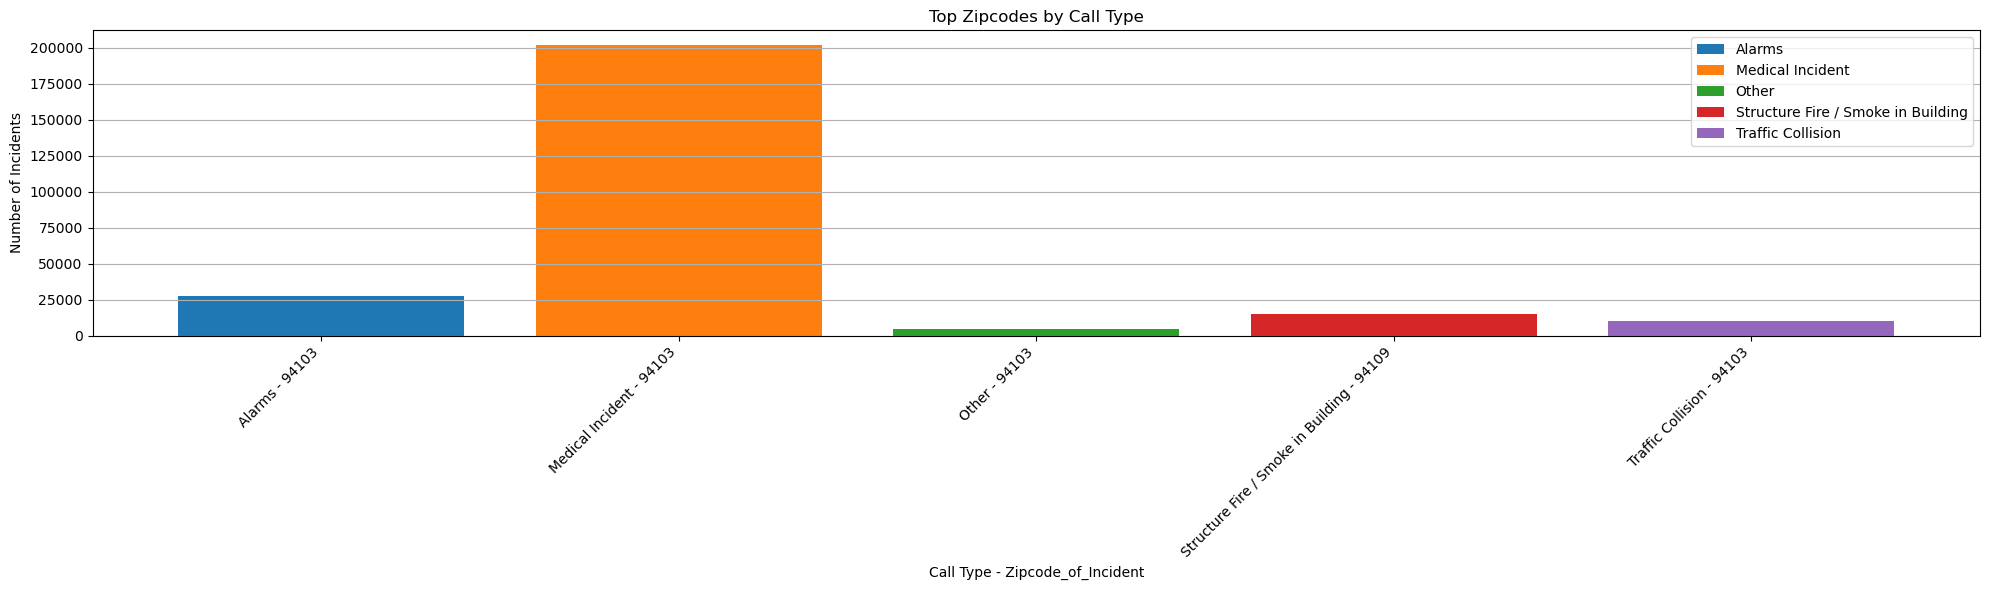

In [35]:
# Get the Zipcode_of_Incident with the highest number of incidents for each of the top 5 call types
top_zipcodes_by_call_type_df = spark.sql("""
    SELECT c.Call_Type, c.Zipcode_of_Incident, c.counts
    FROM (
        SELECT Call_Type, Zipcode_of_Incident, count(*) as counts,
               ROW_NUMBER() OVER(PARTITION BY Call_Type ORDER BY count(*) DESC) as row_num
        FROM calls_data
        WHERE Call_Type IN (SELECT Call_Type FROM (
            SELECT Call_Type, count(*) as counts
                FROM calls_data
                GROUP BY Call_Type
                ORDER BY counts DESC
                LIMIT 5       
        
        ))
        GROUP BY Call_Type, Zipcode_of_Incident
    ) c
    WHERE c.row_num = 1
""")

# Convert the result to Pandas DataFrame for plotting
top_zipcodes_by_call_type_pd = top_zipcodes_by_call_type_df.toPandas()

# Plotting
plt.figure(figsize=(20, 6))
for call_type in top_zipcodes_by_call_type_pd['Call_Type'].unique():
    data = top_zipcodes_by_call_type_pd[top_zipcodes_by_call_type_pd['Call_Type'] == call_type]
    plt.bar(data['Call_Type'] + ' - ' + data['Zipcode_of_Incident'], data['counts'], label=call_type)
plt.xlabel("Call Type - Zipcode_of_Incident")
plt.ylabel("Number of Incidents")
plt.title("Top Zipcodes by Call Type")
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [36]:
# Stop the Spark session
spark.stop()